In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libsvm.svmutil import *
import plotly.express as ex
import chartify as ch

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from plotnine import *

%matplotlib inline

In [2]:
df = pd.read_csv('./hw2/training.csv', sep=',')

In [3]:
# check data
df.head(3)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,...,3,2,0,7,3,3,0,0,0,0


In [4]:
# list columns
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [5]:
# check if nan

df.isnull().values.any()

False

In [6]:
df.groupby('Attrition').count()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,,,
No,987,987,987,987,987,987,987,987,987,987,...,987,987,987,987,987,987,987,987,987,987
Yes,190,190,190,190,190,190,190,190,190,190,...,190,190,190,190,190,190,190,190,190,190


In [7]:
def draw_single_feature(df, feature):
    return ggplot(df) + geom_bar(aes(x = feature))

def draw_mix_feature(df, x, part = 'Attrition'):
    return ggplot(df) + geom_bar(aes(x = x, fill = part))

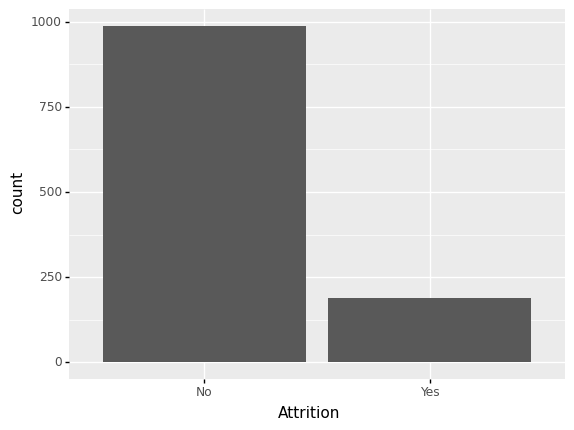

<ggplot: (-9223371916653182000)>

In [8]:
draw_single_feature(df, 'Attrition')

In [26]:
def convert_to_category(df, old_col, new_col, mapper):
    df[new_col] = df[old_col].apply(mapper)
    return df

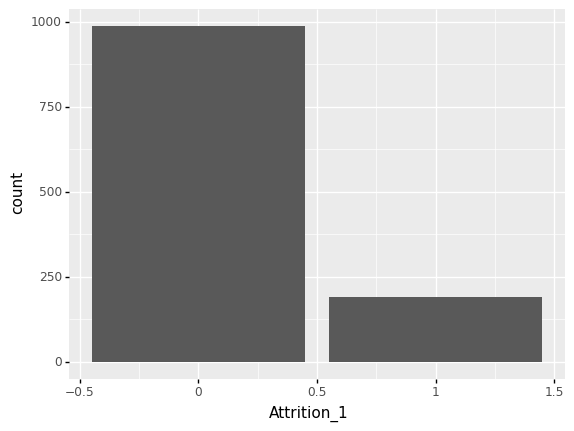

<ggplot: (-9223371916650345608)>

In [27]:
def attrition_mapper(attrition):
    if attrition == 'Yes':
        return 1
    else:
        return 0
    
df = convert_to_category(df, 'Attrition', 'Attrition_1', attrition_mapper)

draw_single_feature(df, 'Attrition_1')

min max of age is 18 60


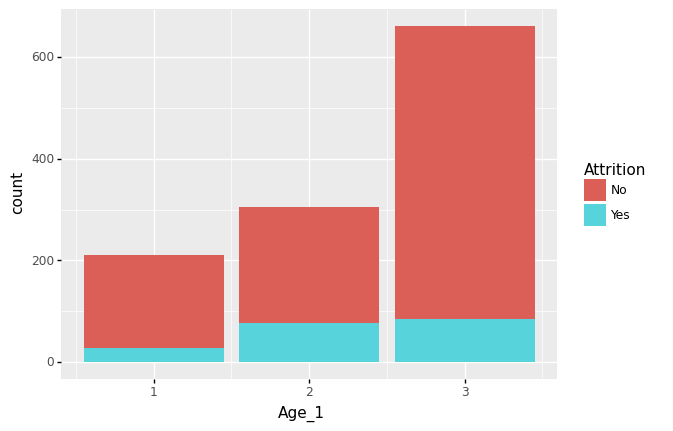

<ggplot: (-9223371916650291740)>

In [28]:
# Age
def age_mapper(age):
    if age <= 30:
        return 2
    elif 31 <= age <= 45:
        return 3
    else:
        return 1
print("min max of age is {} {}".format(df['Age'].min(), df['Age'].max()))
      
df = convert_to_category(df, 'Age', 'Age_1', age_mapper)

draw_mix_feature(df, 'Age_1')

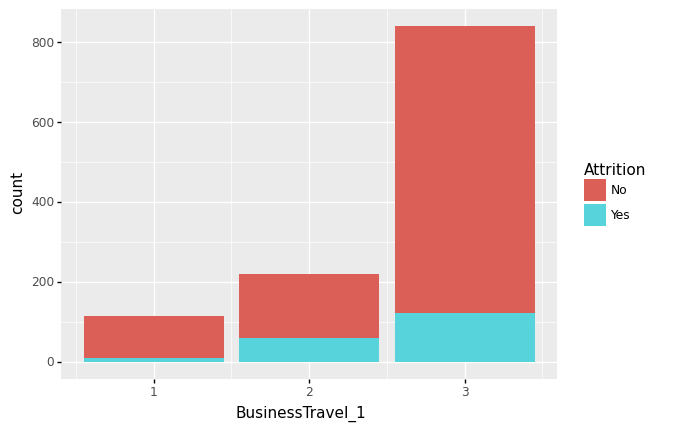

<ggplot: (-9223371916650185860)>

In [29]:
# BusinessTravel
def travel_mapper(travel):
    if travel == 'Travel_Rarely':
        return 3
    elif travel == 'Travel_Frequently':
        return 2
    else:
        return 1

df = convert_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)

draw_mix_feature(df, 'BusinessTravel_1')

['Sales' 'Research & Development' 'Human Resources']


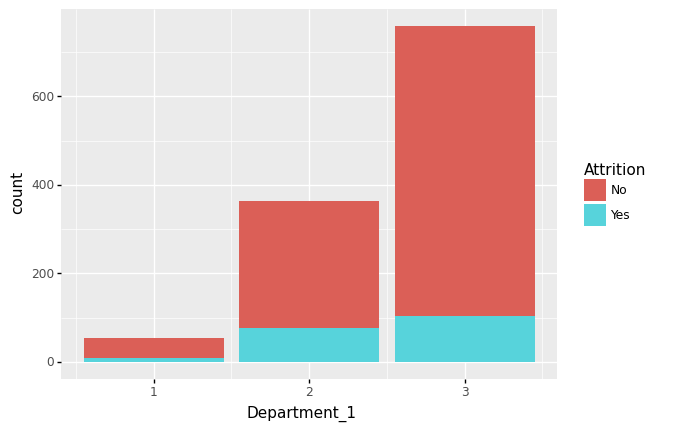

<ggplot: (-9223371916650168768)>

In [30]:
# Department

print(df['Department'].unique())

def depart_mapper(depart):
    if depart == 'Human Resources':
        return 1
    elif depart == 'Sales':
        return 2
    else:
        return 3
    
df = convert_to_category(df, 'Department', 'Department_1', depart_mapper)

draw_mix_feature(df, 'Department_1')

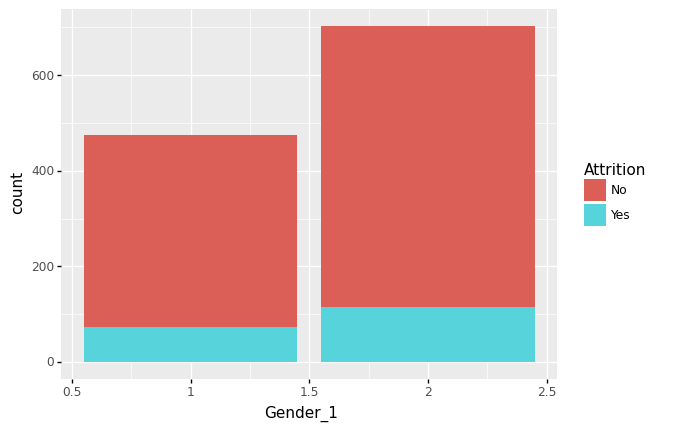

<ggplot: (-9223371916650229748)>

In [31]:
# Gender
def gender_mapper(gender):
    if gender == 'Female':
        return 1
    else:
        return 2
    
df = convert_to_category(df, 'Gender', 'Gender_1', gender_mapper)

draw_mix_feature(df, 'Gender_1')

In [32]:
# build_fold_indices <- function(fold) {
#   test_fold <- 1:fold
#   shifted <- (test_fold + 1)
#   valid_fold <- ifelse((shifted > fold), shifted %% fold, shifted)
#   fold_indices <- data.frame(test = test_fold, valid = valid_fold)
#   return(fold_indices)
# }

def build_fold_indices(fold):
    test_fold = list(range(0, fold))
    shifted = list(range(1, fold+1))
    valid_fold = [0 if (shifted[x] == fold) 
                  else shifted[x]
                  for x in test_fold]
    fold_indices = pd.DataFrame({'test': test_fold, 'valid': valid_fold})
    return fold_indices

In [33]:
# pick_out_indices <- function(total_rows, fold, ...) {
#   indices <- c()
#   for (i in list(...)) {
#     indices <- append(indices, seq(i, total_rows, fold))
#   }
#   indices <- unique(indices) 
#   return(indices)
# }
def pick_out_indices(total_rows, fold, *indices):
    rows = []
    for i in indices:
        rows.extend(range(i, total_rows, fold))

    return list(set(rows))

In [34]:
# get_by_exclude <- function(df, fold, ...) {
#   total_rows <- nrow(df)
#   exclude <- pick_out_indices(total_rows, fold, ...)
#   excluded <- df[-exclude,]
#   return(excluded)
# }
def get_by_exclude(df, fold, *excludes):
    total_rows = len(df.index)
    excluded_indices = pick_out_indices(total_rows, fold, *excludes)
    excluded_frame = df.drop(excluded_indices, axis=0)
    return excluded_frame

In [35]:
# get_by_index <- function(df, fold, ...) {
#   total_rows <- nrow(df)
#   include <- pick_out_indices(total_rows, fold, ...)
#   included <- df[include,]
#   return(included)
# }
def get_by_index(df, fold, *includes):
    total_rows = len(df.index)
    included_indices = pick_out_indices(total_rows, fold, *includes)
    included_frame = df.loc[included_indices]
    return included_frame

In [36]:
# subset_by_fold <- function(df, fold, index, indices){
#   training_frame <- get_by_exclude(df,
#                                    fold,
#                                    indices[index, ]$test,
#                                    indices[index, ]$valid)
#   validation_frame <- get_by_index(df, fold, indices[index, ]$valid)
#   testing_frame <- get_by_index(df, fold, indices[index, ]$test)  
#   return(list(training=training_frame,
#               validation=validation_frame,
#               testing=testing_frame))
# }
def subset_by_fold(df, fold, index, indices):
    training = get_by_exclude(df, fold,
                              indices.at[index, 'test'],
                              indices.at[index, 'valid'])
    validation = get_by_index(df, fold,
                              indices.at[index, 'valid'])
    testing = get_by_index(df, fold,
                           indices.at[index, 'test'])
    return {
        'training': training,
        'validation': validation,
        'testing': testing
    }

In [38]:
fold = 5
fold_indices = build_fold_indices(fold)
# for index in range(0, fold):
index = 0
splitted = subset_by_fold(df, fold, index, fold_indices)

print(splitted['training'].columns)

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_1',
       'Age_1', 'Department_1', 'Gender_1', 'BusinessTravel_1'],
      dtype='object')


In [55]:
Y = splitted['training'][['Attrition_1']]
Y

,Attrition_1
2,1
3,0
4,0
7,0
8,0
...,...
1168,0
1169,0
1172,0
1173,0


In [41]:
X = splitted['training'][['Age_1', 'Department_1', 'Gender_1', 'BusinessTravel_1']]
X

,Age_1,Department_1,Gender_1,BusinessTravel_1
2,3,3,2,3
3,3,3,1,2
4,2,3,2,3
7,2,3,2,3
8,3,3,2,3
...,...,...,...,...
1168,3,3,1,3
1169,2,3,2,3
1172,3,3,2,1
1173,2,2,1,3


In [44]:
lg = LogisticRegression()
lg.fit(X, Y.values.ravel())

LogisticRegression()

In [53]:
pred = lg.predict(splitted['validation'][['Age_1', 'Department_1', 'Gender_1', 'BusinessTravel_1']])
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [47]:
Y_validation = splitted['validation'][['Attrition_1']].values.ravel()

In [49]:
print(classification_report(Y_validation, pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       209
           1       0.00      0.00      0.00        27

    accuracy                           0.89       236
   macro avg       0.44      0.50      0.47       236
weighted avg       0.78      0.89      0.83       236



C:\scoop\apps\miniconda3\current\envs\jupyter\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
